In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from scipy.stats import norm
from scipy import stats

import xgboost as xgb
from sklearn.model_selection import train_test_split

In [57]:
train = pd.read_csv("../../../mltestdata/03_predict_hourly_wage/Income_training.csv")
test = pd.read_csv("../../../mltestdata/03_predict_hourly_wage/Income_testing.csv")

# Preprocessiong
* * * *

欠損値も特にないため、省略

* * *

# Modeling
* * * * *

In [60]:
train_target = train.compositeHourlyWages.values

test_ID = test['ID']
test.drop("ID", axis = 1, inplace = True)

train.drop(['compositeHourlyWages'], axis=1, inplace=True)

In [61]:
X_train, X_test, y_train, y_test = train_test_split(train,train_target,test_size=0.2,random_state=0)

### 1. Validation with local train

In [77]:
# xgboostモデルの作成
reg = xgb.XGBRegressor()
reg.fit(X_train, y_train)

# パラメータを設定した場合は下記で設定可能
#ind_params = {'objective': 'reg:linear'}
#reg = xgb.XGBRegressor(**ind_params)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [78]:
y_train_predict = reg.predict(X_train)
y_pred = reg.predict(X_test)

In [79]:
# The error metric: RMSE
from sklearn.metrics import mean_squared_error, r2_score, make_scorer

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

print("RMSE from local train: ", rmse(y_test, y_pred))
print("MSE from local train: ", mean_squared_error(y_test, y_pred))
print("R2 from local train: ", r2_score(y_test, y_pred))

RMSE from local train:  0.366966080046
MSE from local train:  0.134664103904
R2 from local train:  0.408541661922


### 2. Validation with GridSearch

In [80]:
from sklearn.model_selection import GridSearchCV

In [81]:
# XGBoost params
xgb_params = {
    'objective' : ['reg:gamma','reg:linear'],
    'learning_rate' : [0.05,0.1],
    'n_estimators' : [50,100,200],
    'max_depth' : [2,4,6],
    'subsample' : [0.8,0.85,0.9,0.95],
    'colsample_bytree' : [0.5,1.0],
    'min_child_weight' : [5,10,15]
}

In [105]:
#scoring_func = make_scorer(mean_squared_error)

#grid = GridSearchCV(reg,xgb_params,scoring=scoring_func,cv=5,n_jobs=-1)
grid = GridSearchCV(reg,xgb_params,scoring='neg_mean_squared_error',cv=5,n_jobs=-1)

grid.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'objective': ['reg:gamma', 'reg:linear'], 'learning_rate': [0.05, 0.1], 'n_estimators': [50, 100, 200], 'max_depth': [2, 4, 6], 'subsample': [0.8, 0.85, 0.9, 0.95], 'colsample_bytree': [0.5, 1.0], 'min_child_weight': [5, 10, 15]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=0)

In [106]:
# Best Params and Score
print("Best params: ", grid.best_params_)
print("Best Estimator: ", grid.best_estimator_)

print("MSE: ", grid.best_score_)

# best_score_ : Mean cross-validated score of the best_estimator

Best params:  {'colsample_bytree': 1.0, 'learning_rate': 0.05, 'max_depth': 2, 'min_child_weight': 15, 'n_estimators': 200, 'objective': 'reg:gamma', 'subsample': 0.85}
Best Estimator:  XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1.0, gamma=0, learning_rate=0.05, max_delta_step=0,
       max_depth=2, min_child_weight=15, missing=None, n_estimators=200,
       n_jobs=1, nthread=None, objective='reg:gamma', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.85)
MSE:  -0.127260886854


In [107]:
# The result of combination
index = 1
for params, mean_score, scores in grid.grid_scores_:
    print("%d) %0.3f (+/-%0.03f) " % (index, mean_score, scores.std() / 2))
    print("Params: %r" % params)
    print("_"*30)
    index = index + 1

/Users/suzukiry/lab/March/lib/python3.6/site-packages/sklearn/model_selection/_search.py:747: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


1) -0.680 (+/-0.013) 
Params: {'colsample_bytree': 0.5, 'learning_rate': 0.05, 'max_depth': 2, 'min_child_weight': 5, 'n_estimators': 50, 'objective': 'reg:gamma', 'subsample': 0.8}
______________________________
2) -0.680 (+/-0.013) 
Params: {'colsample_bytree': 0.5, 'learning_rate': 0.05, 'max_depth': 2, 'min_child_weight': 5, 'n_estimators': 50, 'objective': 'reg:gamma', 'subsample': 0.85}
______________________________
3) -0.680 (+/-0.013) 
Params: {'colsample_bytree': 0.5, 'learning_rate': 0.05, 'max_depth': 2, 'min_child_weight': 5, 'n_estimators': 50, 'objective': 'reg:gamma', 'subsample': 0.9}
______________________________
4) -0.680 (+/-0.013) 
Params: {'colsample_bytree': 0.5, 'learning_rate': 0.05, 'max_depth': 2, 'min_child_weight': 5, 'n_estimators': 50, 'objective': 'reg:gamma', 'subsample': 0.95}
______________________________
5) -0.173 (+/-0.005) 
Params: {'colsample_bytree': 0.5, 'learning_rate': 0.05, 'max_depth': 2, 'min_child_weight': 5, 'n_estimators': 50, 'objecti

In [108]:
# 改めて最適パラメータで学習
gdm = xgb.XGBRegressor(**grid.best_params_) # 6.01679534923
#gdm = xgb.XGBRegressor(**xgb_params) # 6.0907929398
gdm.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1.0, gamma=0, learning_rate=0.05, max_delta_step=0,
       max_depth=2, min_child_weight=15, missing=None, n_estimators=200,
       n_jobs=1, nthread=None, objective='reg:gamma', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.85)

In [109]:
y_pred_gs = gdm.predict(X_test)

In [110]:
# The error metric: RMSE
print("RMSE from local train: ", rmse(y_test, y_pred_gs))
print("MSE from local train: ", mean_squared_error(y_test, y_pred_gs))
print("R2 from local train: ", r2_score(y_test, y_pred_gs))

RMSE from local train:  0.364600677399
MSE from local train:  0.13293365396
R2 from local train:  0.416141972758


__Findings__
- RMSEがやや下がっている。
- R2がやや増えている。過学習までには至っていないと判断。

### 3. Validation with sklearn cv (normal k-fold)

In [113]:
# WIP

### 4. Validation with sklearn cv (Stritified k-fold)

In [114]:
# WIP

#kf=StratifiedKFold(n_splits=5, shuffle=True, random_state=2017)

'''
clf = GridSearchCV(xgb_model, parameters, n_jobs=5, 
                   cv=StratifiedKFold(train['QuoteConversion_Flag'], n_folds=5, shuffle=True), 
                   scoring='roc_auc',
                   verbose=2, refit=True)

clf.fit(train[features], train["QuoteConversion_Flag"])
'''


'\nclf = GridSearchCV(xgb_model, parameters, n_jobs=5, \n                   cv=StratifiedKFold(train[\'QuoteConversion_Flag\'], n_folds=5, shuffle=True), \n                   scoring=\'roc_auc\',\n                   verbose=2, refit=True)\n\nclf.fit(train[features], train["QuoteConversion_Flag"])\n'

# Evaluation

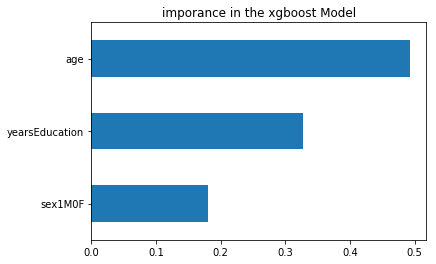

In [15]:
# feature importance のプロット
importances = pd.Series(gdm.feature_importances_, index = train.columns)
importances = importances.sort_values()
importances.plot(kind = "barh")
plt.title("imporance in the xgboost Model")
plt.show()

# Submission

In [111]:
predictions = gdm.predict(test)

In [112]:
sub = pd.DataFrame()
sub['ID'] = test_ID
sub['compositeHourlyWages'] = predictions
sub.to_csv('rs_hourly_submission_24-Dec-2017_v02.csv',index=False)